### Run this cell only if you are working in Google Colab

In [1]:
import os, datetime
from google.colab import drive

drive.mount('/content/drive')

PATH = os.path.join('drive','MyDrive','hands-free_cursor')
os.chdir(os.path.join(PATH,'src2'))
os.listdir()

Mounted at /content/drive


['Preprocessor.py', '__pycache__', 'Model_preparation.ipynb']

In [2]:
# %load_ext tensorboard

from Preprocessor import Preprocessor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import pandas as pd
import numpy as np
import datetime
import pickle
import time
import json
import cv2
import os

# Data preparation

## CSV and JSON data (Data info)

In [ ]:
INPUT_PATH = os.path.join('..', 'data', 'face_cursor')

data_info = None
for sub_num, subject in enumerate(os.listdir(INPUT_PATH)):
    for ses_num, session in enumerate(os.listdir(os.path.join(INPUT_PATH, subject))):
        csv_path = glob(os.path.join(INPUT_PATH, subject, session, '*.csv'))[0]
        json_path = glob(os.path.join(INPUT_PATH, subject, session, '*.json'))[0]

        # Loading data
        temp_df = pd.read_csv(csv_path)
        with open(json_path, 'r') as file:
            session_data = json.load(file)
        assert session_data['images']==temp_df.shape[0], f'Incorrect number of images in:\n{subject}\n{session}'

        # Creating new columns
        temp_df['subject'] = ['subject_'+str(sub_num)]*session_data['images']
        temp_df['file_name'] = temp_df['file_name'].apply(lambda x: os.path.join(INPUT_PATH, subject, session, 'images', x))
        temp_df = temp_df.rename(columns={'file_name':'file_path'})

        if sub_num==0 and ses_num==0:
            data_info = temp_df
        else:
            data_info = pd.concat([data_info,temp_df], axis=0)
data_info = data_info.reset_index().drop('index',axis=1)

data_info.head()

,file_path,ref_x,ref_y,ref_w,ref_h,kpt1_x,kpt1_y,kpt2_x,kpt2_y,kpt3_x,kpt3_y,kpt4_x,kpt4_y,kpt5_x,kpt5_y,kpt6_x,kpt6_y,label,subject
0,../data/face_cursor/subject_1/2023_09_06-19_06...,0.467098,0.388244,0.261640,0.348852,0.552614,0.473904,0.659617,0.472428,0.611631,0.545088,0.608068,0.624877,0.481930,0.525672,0.710058,0.525424,0,subject_0
1,../data/face_cursor/subject_1/2023_09_06-19_06...,0.466141,0.391053,0.258238,0.344316,0.553824,0.473932,0.659307,0.478458,0.611197,0.548368,0.604669,0.625406,0.479953,0.518740,0.705629,0.531455,0,subject_0
2,../data/face_cursor/subject_1/2023_09_06-19_06...,0.465630,0.390525,0.259856,0.346467,0.550534,0.473554,0.656689,0.475675,0.607177,0.545697,0.602508,0.624783,0.479656,0.522856,0.707342,0.530774,0,subject_0
3,../data/face_cursor/subject_1/2023_09_06-19_06...,0.467625,0.393689,0.261153,0.348204,0.547975,0.476955,0.657321,0.474410,0.605751,0.544885,0.603376,0.626516,0.480258,0.532162,0.712836,0.531642,0,subject_0
4,../data/face_cursor/subject_1/2023_09_06-19_06...,0.478740,0.396700,0.260472,0.347295,0.559205,0.480044,0.669421,0.475408,0.619390,0.546530,0.617024,0.629674,0.489144,0.536649,0.722839,0.532107,0,subject_0


In [ ]:
data_info['subject'].value_counts()

subject_0    900
subject_1    900
Name: subject, dtype: int64

In [ ]:
data_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   file_path  1800 non-null   object 
 1   ref_x      1800 non-null   float64
 2   ref_y      1800 non-null   float64
 3   ref_w      1800 non-null   float64
 4   ref_h      1800 non-null   float64
 5   kpt1_x     1800 non-null   float64
 6   kpt1_y     1800 non-null   float64
 7   kpt2_x     1800 non-null   float64
 8   kpt2_y     1800 non-null   float64
 9   kpt3_x     1800 non-null   float64
 10  kpt3_y     1800 non-null   float64
 11  kpt4_x     1800 non-null   float64
 12  kpt4_y     1800 non-null   float64
 13  kpt5_x     1800 non-null   float64
 14  kpt5_y     1800 non-null   float64
 15  kpt6_x     1800 non-null   float64
 16  kpt6_y     1800 non-null   float64
 17  label      1800 non-null   int64  
 18  subject    1800 non-null   object 
dtypes: float64(16), int64(1), object(2)
memory usage

In [ ]:
data_info.describe()

,ref_x,ref_y,ref_w,ref_h,kpt1_x,kpt1_y,kpt2_x,kpt2_y,kpt3_x,kpt3_y,kpt4_x,kpt4_y,kpt5_x,kpt5_y,kpt6_x,kpt6_y,label
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,0.418610,0.324431,0.284887,0.379837,0.506711,0.414300,0.621156,0.417250,0.563979,0.492235,0.561430,0.580554,0.436209,0.468777,0.683887,0.476449,4.000000
std,0.074545,0.093499,0.040196,0.053585,0.083095,0.092929,0.077753,0.091757,0.098048,0.099745,0.088270,0.093512,0.070788,0.089310,0.057826,0.087049,2.582706
min,0.162404,0.026744,0.204989,0.273319,0.211958,0.094097,0.322656,0.123514,0.212860,0.159878,0.245775,0.280896,0.185469,0.172619,0.503661,0.231896,0.000000
25%,0.370251,0.264294,0.255068,0.340091,0.452039,0.354589,0.576989,0.360878,0.501344,0.426173,0.504040,0.522466,0.389874,0.411509,0.651733,0.419519,2.000000
50%,0.408067,0.320034,0.277153,0.369526,0.501065,0.413914,0.616160,0.420832,0.565360,0.490278,0.559571,0.578611,0.426654,0.469730,0.675253,0.490427,4.000000
75%,0.471794,0.379360,0.309442,0.412579,0.569224,0.463384,0.676263,0.471151,0.642001,0.566843,0.629625,0.652071,0.487453,0.518409,0.724078,0.520936,6.000000
max,0.622360,0.569889,0.393947,0.525204,0.697876,0.676126,0.804019,0.665980,0.786794,0.760538,0.747542,0.830550,0.630786,0.713893,0.842490,0.689522,8.000000


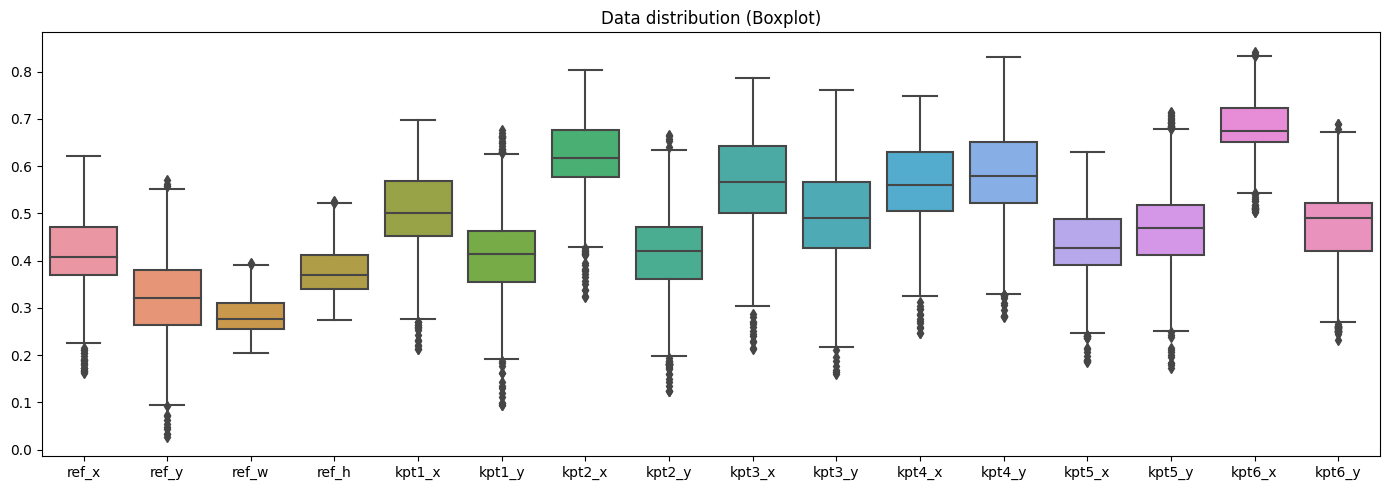

In [ ]:
plt.figure(figsize=(14,5))
sns.boxplot(data_info.drop(['file_path','label','subject'], axis=1))
plt.title('Data distribution (Boxplot)')
plt.tight_layout()
plt.show()

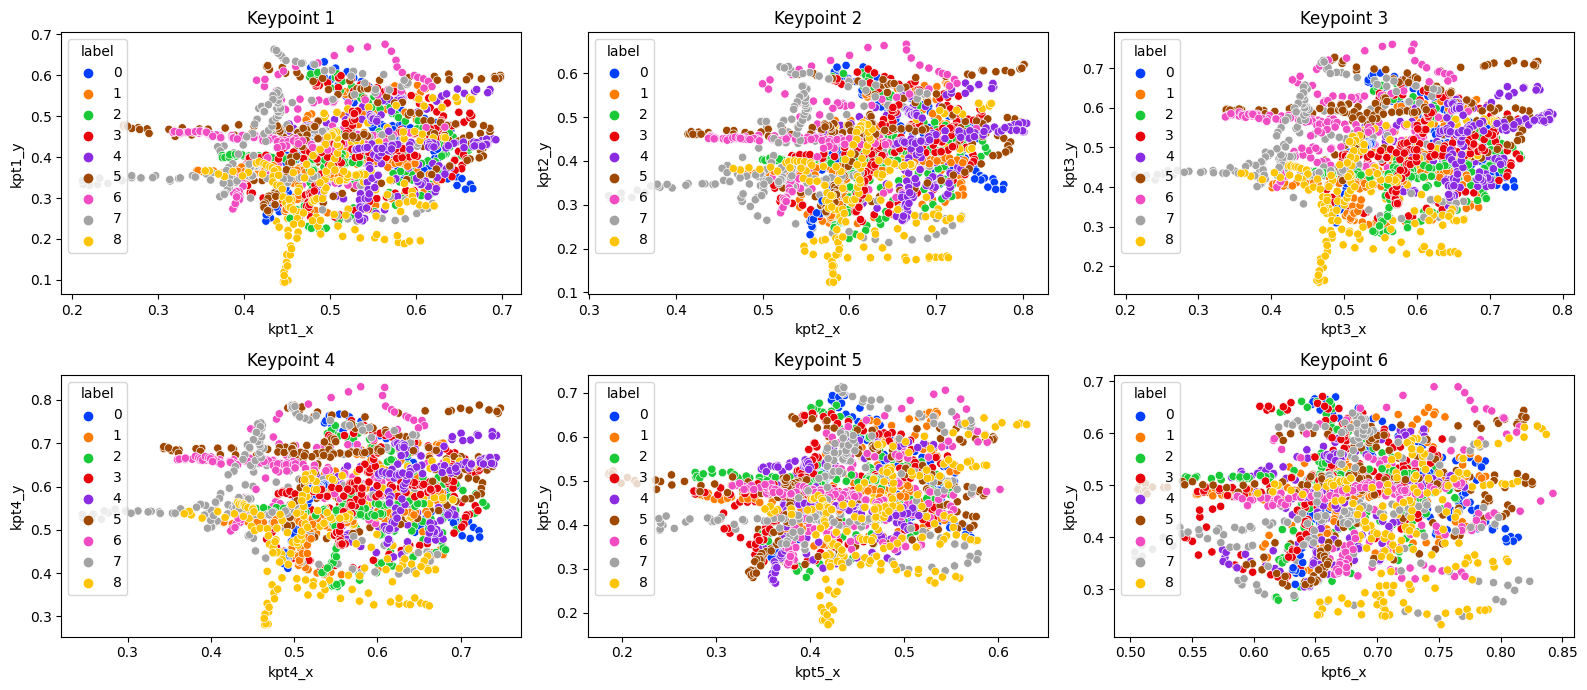

In [5]:
axs = [['kpt1_x', 'kpt2_x', 'kpt3_x', 'kpt4_x', 'kpt5_x', 'kpt6_x'],
       ['kpt1_y', 'kpt2_y', 'kpt3_y', 'kpt4_y', 'kpt5_y', 'kpt6_y']]

plt.figure(figsize=(16,7))
for i in range(len(axs[0])):
    plt.subplot(2, 3, i+1)
    sns.scatterplot(data_info, x=axs[0][i], y=axs[1][i], hue='label', palette='bright')
    plt.title(f'Keypoint {i+1}')
plt.tight_layout()
plt.show()

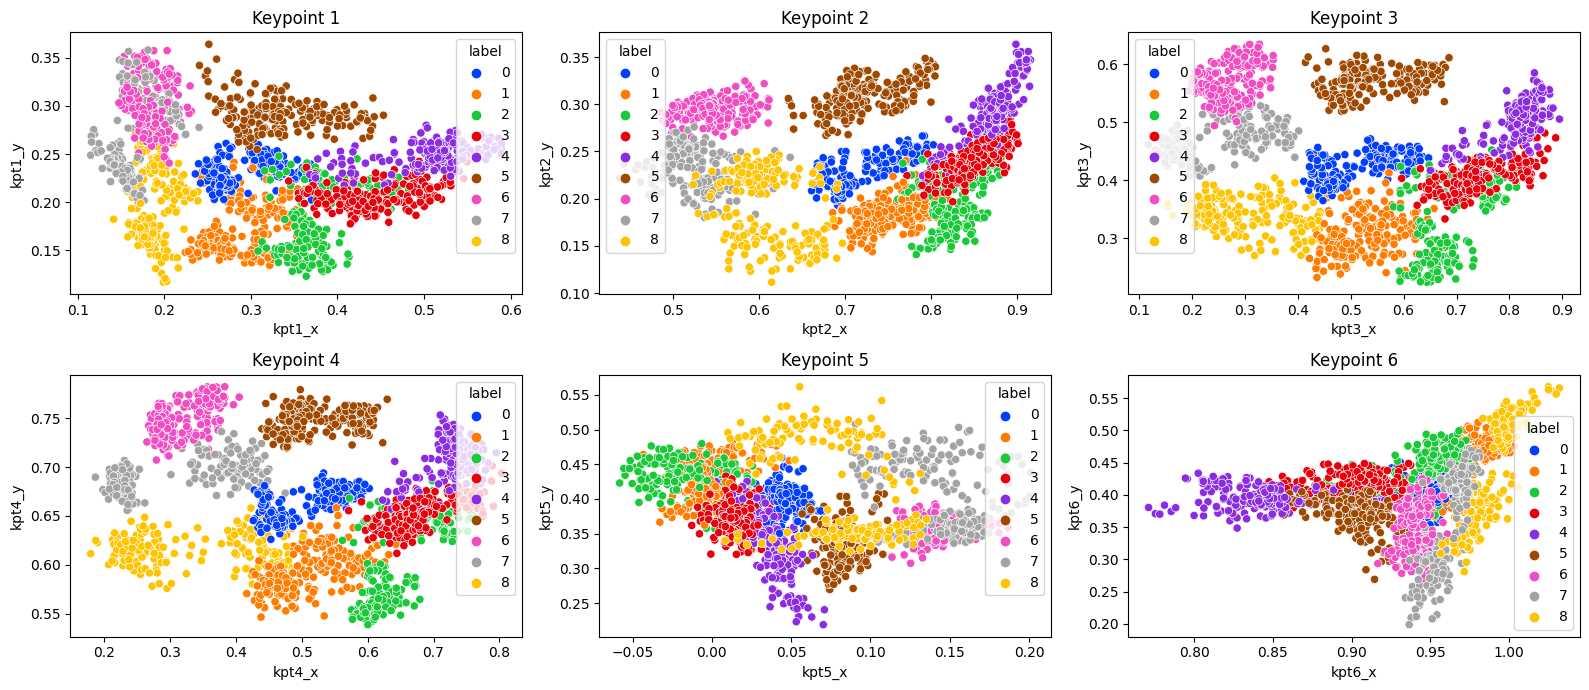

In [6]:
X = pd.concat([(data_info[axs[0]]-data_info[['ref_x']].values)/data_info[['ref_w']].values,
               (data_info[axs[1]]-data_info[['ref_y']].values)/data_info[['ref_h']].values],
               axis=1)

plt.figure(figsize=(16,7))
for i in range(len(axs[0])):
    plt.subplot(2, 3, i+1)
    sns.scatterplot(X, x=axs[0][i], y=axs[1][i], hue=data_info['label'], palette='bright')
    plt.title(f'Keypoint {i+1}')
plt.tight_layout()
plt.show()

In [7]:
X.describe()

,kpt1_x,kpt2_x,kpt3_x,kpt4_x,kpt5_x,kpt6_x,kpt1_y,kpt2_y,kpt3_y,kpt4_y,kpt5_y,kpt6_y
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,0.310182,0.714390,0.515578,0.506722,0.058100,0.932748,0.233975,0.239709,0.433747,0.669670,0.385057,0.400908
std,0.119734,0.123417,0.205947,0.161532,0.057407,0.046540,0.051641,0.050585,0.100332,0.058936,0.053178,0.056855
min,0.115080,0.438008,0.118345,0.179557,-0.058119,0.770855,0.116799,0.111615,0.224081,0.538808,0.218771,0.198533
25%,0.192516,0.594069,0.321740,0.388421,0.012205,0.908335,0.200446,0.205298,0.358368,0.626204,0.347080,0.373988
50%,0.301396,0.727836,0.516008,0.504401,0.045475,0.942575,0.231358,0.235614,0.427937,0.668080,0.379406,0.402672
75%,0.401521,0.824121,0.684465,0.642694,0.098379,0.965595,0.271621,0.284420,0.520743,0.721015,0.421627,0.429048
max,0.589456,0.915526,0.894432,0.803342,0.200982,1.032303,0.364110,0.363577,0.634605,0.782221,0.561683,0.567913


In [8]:
y = data_info['label']
classes = {0:'center', 1:'up', 2:'left/up', 3:'left', 4:'left/down',
           5:'down', 6:'right/down', 7:'right', 8:'right/up'}

## Eyes capture (Images)

In [ ]:
size = (180, 180)
images = np.zeros((data_info.shape[0], size[1], size[0], 3))
for i, image_path in enumerate(data_info['file_path']):
    image  = plt.imread(image_path)
    images[i] = cv2.resize(image, size)
images = images/255
images.shape

(1800, 180, 180, 3)

In [ ]:
preprocessor = Preprocessor()
enhanced_images = np.copy(images)
for i, image in enumerate(enhanced_images):
  enhanced_images[i] = preprocessor.apply((image*255).astype(np.uint8), limit=2.0, grid=(8,8))
enhanced_images /= 255
enhanced_images.shape

(1800, 180, 180, 3)

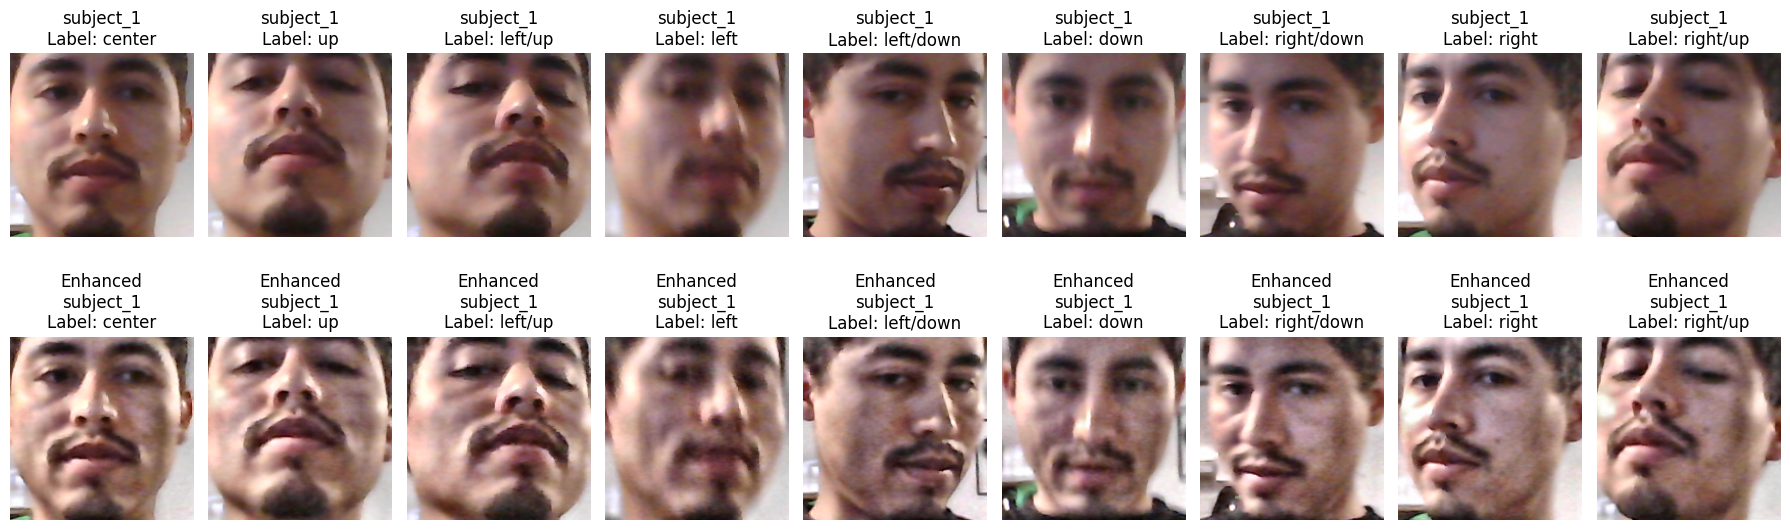

In [ ]:
fig, axes = plt.subplots(2, 9, figsize=(18,6))
for i in range(int(len(axes.flatten())/2)):
  ax1 = axes.flatten()[i]
  ax2 = axes.flatten()[i+int(len(axes.flatten())/2)]
  idx = np.where(y==i)[0][110]
  ax1.imshow(images[idx])
  ax1.set_title(f"{data_info['subject'].iloc[idx]}\nLabel: {classes[y.iloc[idx]]}")
  ax1.axis('off')
  ax2.imshow(enhanced_images[idx])
  ax2.set_title(f"Enhanced\n{data_info['subject'].iloc[idx]}\nLabel: {classes[y.iloc[idx]]}")
  ax2.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Saving the data:
with open(os.path.join('..', 'data', 'processed_data2.pkl'), 'wb') as f:
    pickle.dump([data_info, images], f)


# Classic model creation

In [3]:
# Getting back the data:
with open(os.path.join('..', 'data', 'processed_data2.pkl'), 'rb') as f:
    data_info, images = pickle.load(f)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size = 0.2, random_state = 69, stratify=y)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1440, 12), (1440,), (360, 12), (360,))

## Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegressionCV

lr_cv = LogisticRegressionCV(Cs=int(5), cv=5, max_iter=5000)
lr_cv.fit(X_train, y_train)

LogisticRegressionCV(Cs=5, cv=5, max_iter=5000)

In [11]:
lr_cv.coef_.mean(axis=0)

array([ 6.94752897e-13, -7.22819335e-12, -3.93245930e-11,  5.89592572e-12,
        1.67169982e-11, -1.65130132e-11,  1.00420413e-11,  3.60245167e-12,
        3.01064852e-11, -1.60350252e-11, -1.52119305e-11,  5.76832409e-11])

In [12]:
from sklearn.metrics import confusion_matrix, classification_report

pred_train = lr_cv.predict(X_train)
pred_test = lr_cv.predict(X_test)

print('\t\tRESULTS IN TRAIN\n')
print(classification_report(y_train, pred_train, target_names=classes.values()))
print('\n')
print('\t\tRESULTS IN TEST\n')
print(classification_report(y_test, pred_test, target_names=classes.values()))

		RESULTS IN TRAIN

              precision    recall  f1-score   support

      center       0.99      1.00      1.00       160
          up       0.96      0.97      0.97       160
     left/up       0.89      0.90      0.89       160
        left       0.91      0.87      0.89       160
   left/down       0.96      0.97      0.96       160
        down       1.00      1.00      1.00       160
  right/down       1.00      1.00      1.00       160
       right       1.00      1.00      1.00       160
    right/up       0.99      0.99      0.99       160

    accuracy                           0.97      1440
   macro avg       0.97      0.97      0.97      1440
weighted avg       0.97      0.97      0.97      1440



		RESULTS IN TEST

              precision    recall  f1-score   support

      center       1.00      1.00      1.00        40
          up       0.95      0.97      0.96        40
     left/up       0.89      0.80      0.84        40
        left       0.80      0.90    

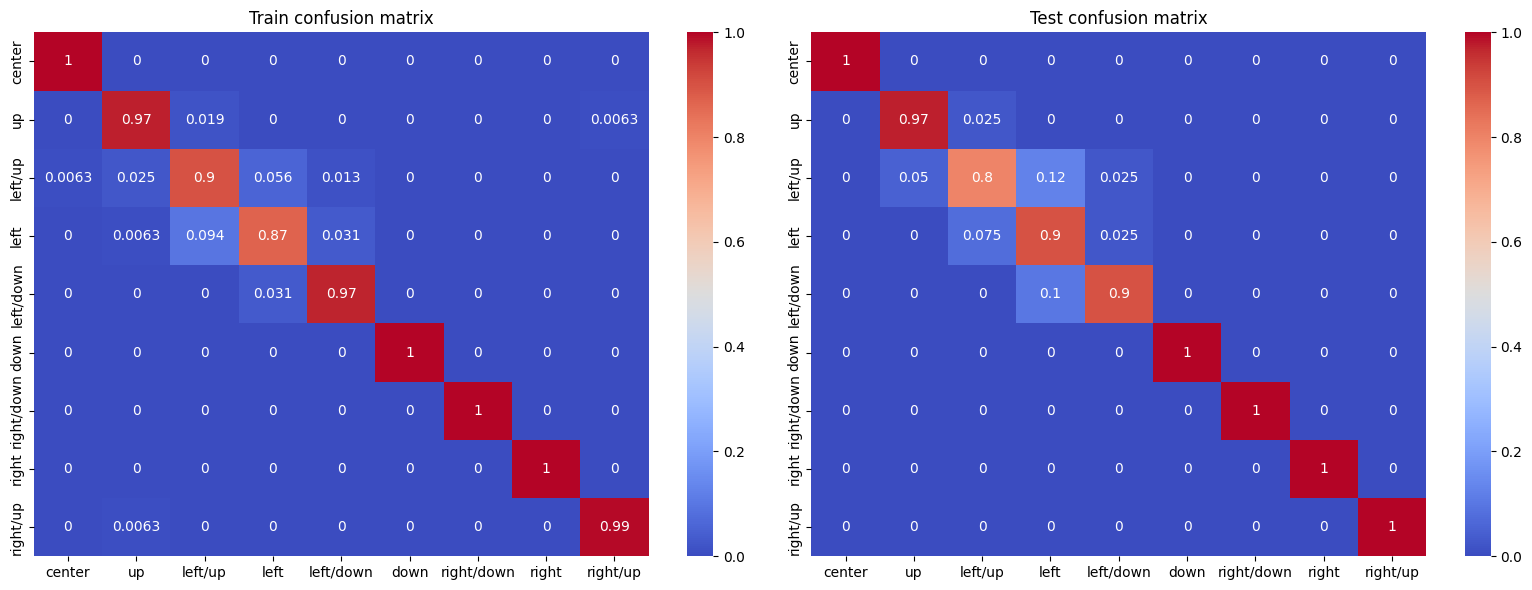

In [13]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.heatmap(confusion_matrix(y_train, pred_train, normalize='true'),
            annot=True, cmap='coolwarm', vmin=0)
plt.title('Train confusion matrix')
plt.xticks(ticks=np.arange(0.5,len(classes),1), labels=classes.values())
plt.yticks(ticks=np.arange(0.5,len(classes),1), labels=classes.values())

plt.subplot(1,2,2)
sns.heatmap(confusion_matrix(y_test, pred_test, normalize='true'),
            annot=True, cmap='coolwarm', vmin=0)
plt.title('Test confusion matrix')
plt.xticks(ticks=np.arange(0.5,len(classes),1), labels=classes.values())
plt.yticks(ticks=np.arange(0.5,len(classes),1), labels=classes.values())
plt.tight_layout()
plt.show()

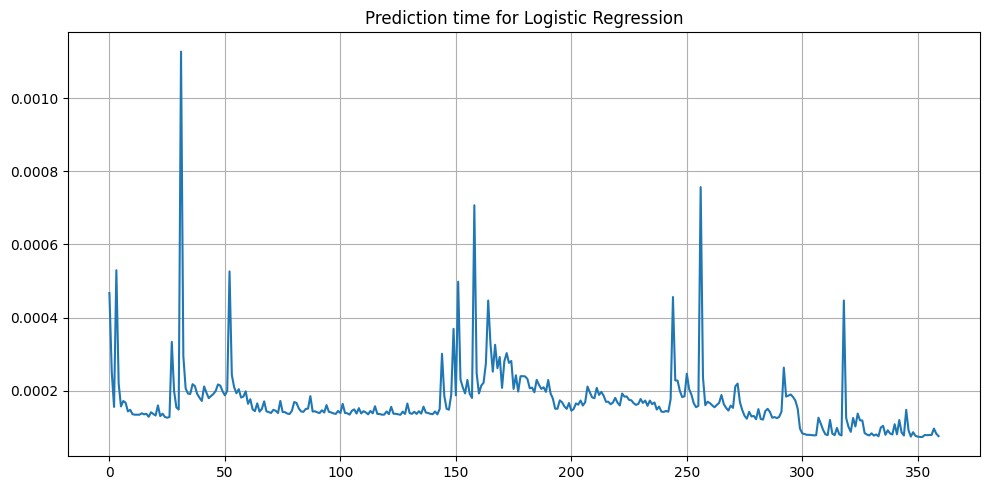

In [14]:
pred_time = []
for sample in X_test:
  start_time = time.time()
  pred = lr_cv.predict(sample.reshape((1,-1)))
  pred_time.append(time.time()-start_time)
plt.figure(figsize=(10, 5))
plt.plot(pred_time)
plt.grid(True)
plt.title('Prediction time for Logistic Regression')
plt.tight_layout()
plt.show()

In [15]:
# Saving the model:
with open(os.path.join('..', 'models', 'cursor_model.pkl'), 'wb') as f:
    pickle.dump(lr_cv, f)

## SVM

In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

param_grid = {'n_estimators': list(range(10,101,10)), 'max_depth': list(range(2,10))}

xgc = xgb.XGBClassifier(random_state=69)
grid = GridSearchCV(xgc, param_grid, cv=5, verbose=0, n_jobs=-1)
grid.fit(X_train, y_train)
grid.best_params_

{'max_depth': 5, 'n_estimators': 70}

In [ ]:
xgc = xgb.XGBClassifier(n_estimators=grid.best_params_['n_estimators'],
                        max_depth=grid.best_params_['max_depth'],
                        random_state=69)
xgc.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=70, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [ ]:
pred_train = xgc.predict(X_train)
pred_test = xgc.predict(X_test)

print('\t\tRESULTS IN TRAIN\n')
print(classification_report(y_train, pred_train, target_names=classes.values()))
print('\n')
print('\t\tRESULTS IN TEST\n')
print(classification_report(y_test, pred_test, target_names=classes.values()))

		RESULTS IN TRAIN

              precision    recall  f1-score   support

      center       1.00      1.00      1.00       160
          up       1.00      1.00      1.00       160
     left/up       1.00      1.00      1.00       160
        left       1.00      1.00      1.00       160
   left/down       1.00      1.00      1.00       160
        down       1.00      1.00      1.00       160
  right/down       1.00      1.00      1.00       160
       right       1.00      1.00      1.00       160
    right/up       1.00      1.00      1.00       160

    accuracy                           1.00      1440
   macro avg       1.00      1.00      1.00      1440
weighted avg       1.00      1.00      1.00      1440



		RESULTS IN TEST

              precision    recall  f1-score   support

      center       0.95      0.95      0.95        40
          up       0.97      0.95      0.96        40
     left/up       0.85      0.82      0.84        40
        left       0.78      0.88    

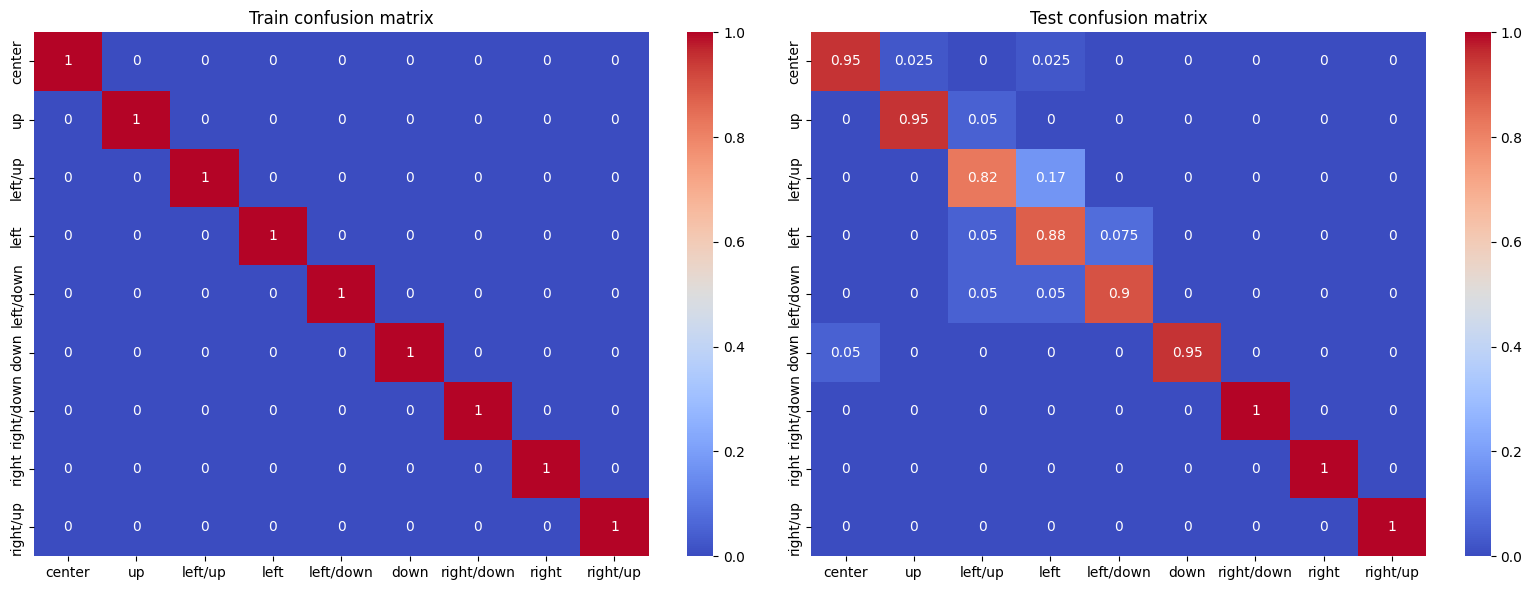

In [ ]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.heatmap(confusion_matrix(y_train, pred_train, normalize='true'),
            annot=True, cmap='coolwarm', vmin=0)
plt.title('Train confusion matrix')
plt.xticks(ticks=np.arange(0.5,len(classes),1), labels=classes.values())
plt.yticks(ticks=np.arange(0.5,len(classes),1), labels=classes.values())

plt.subplot(1,2,2)
sns.heatmap(confusion_matrix(y_test, pred_test, normalize='true'),
            annot=True, cmap='coolwarm', vmin=0)
plt.title('Test confusion matrix')
plt.xticks(ticks=np.arange(0.5,len(classes),1), labels=classes.values())
plt.yticks(ticks=np.arange(0.5,len(classes),1), labels=classes.values())
plt.tight_layout()
plt.show()

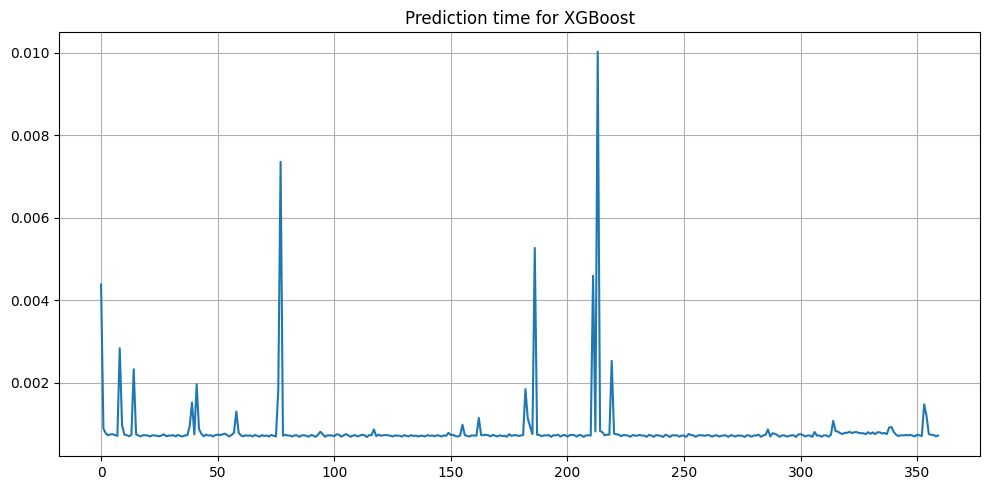

In [ ]:
pred_time = []
for sample in X_test:
  start_time = time.time()
  pred = xgc.predict(sample.reshape((1,-1)))
  pred_time.append(time.time()-start_time)
plt.figure(figsize=(10, 5))
plt.plot(pred_time)
plt.grid(True)
plt.title('Prediction time for XGBoost')
plt.tight_layout()
plt.show()

# Neural-Network model creation

In [ ]:
X_img_tr, X_img_ts, X_ref_tr, X_ref_ts, y_tr, y_ts = train_test_split(enhanced_images,
                                                                      X,
                                                                      data_info[['click_x', 'click_y']],
                                                                      test_size = 0.1,
                                                                      random_state = 69)

X_img_tr.shape, X_img_ts.shape, X_ref_tr.shape, X_ref_ts.shape, y_tr.shape, y_ts.shape

In [ ]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Concatenate
from tensorflow.keras.layers import Flatten, Dropout, Input
from tensorflow.keras.models import Model

def build_model(image_shape, ref_shape, dropout):
  img = Input(shape=image_shape, name='img_input')
  ref = Input(shape=(ref_shape,), name='ref_input')

  cv1 = Conv2D(8, kernel_size=7, activation='relu', name='cv1')(img)
  mp1 = MaxPooling2D(2, name='mp1')(cv1)
  do1 = Dropout(dropout, name='do1')(mp1)

  cv2 = Conv2D(16, kernel_size=7, activation='relu', name='cv2')(do1)
  mp2 = MaxPooling2D(2, name='mp2')(cv2)
  do2 = Dropout(dropout, name='do2')(mp2)

  cv3 = Conv2D(32, kernel_size=7, activation='relu', name='cv3')(do2)
  mp3 = MaxPooling2D(2, name='mp3')(cv3)
  do3 = Dropout(dropout, name='do3')(mp3)

  flt = Flatten(name='flatten')(do3)
  ds1 = Dense(60, activation='sigmoid', name='ds1')(flt)
  do4 = Dropout(dropout, name='do4')(ds1)

  cct = Concatenate(name='concatenate')([do4, ref])
  ds2 = Dense(32, activation='sigmoid', name='ds2')(cct)

  out = Dense(2, activation='sigmoid', name='output')(ds2)

  model = Model([img, ref], [out])

  return model

model = build_model(images[0].shape, 4, dropout=0.1)
model.summary()

In [ ]:
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.metrics import RootMeanSquaredError

batch_size = 64

time_stamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
logdir = os.path.join("logs", time_stamp)
callbacks = [TensorBoard(log_dir=logdir, histogram_freq=1)]

model.compile(optimizer='adam', loss='mse', metrics=RootMeanSquaredError(name='rmse'))

model.fit([X_img_tr, X_ref_tr], y_tr,
          validation_data=([X_img_ts, X_ref_ts], y_ts),
          epochs=150,
          batch_size=batch_size,
          callbacks=callbacks)

In [ ]:
%tensorboard --logdir logs

In [ ]:
# Saving the model:
with open(os.path.join('..', 'models', f'model-{time_stamp}.pkl'), 'wb') as f:
    pickle.dump(model, f)